In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import copy
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# 1. Setup Device
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

# 2. Grab raw data for stat calculation (no normalization yet)
raw_train = datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms.ToTensor())

# Get classes from the dataset object automatically
classes = raw_train.classes
print(f"Detected Classes: {classes}")

# 3. Calculate Mean and Std automatically
# We stack all images into one large tensor [50000, 3, 32, 32]
imgs = torch.stack([img for img, _ in raw_train], dim=3) 

# Calculate mean and std across the batch, height, and width dimensions (dim 0, 2, 3)
# result is [3] — one value for Red, Green, and Blue
calculated_means = imgs.view(3, -1).mean(dim=1).tolist()
calculated_stds = imgs.view(3, -1).std(dim=1).tolist()

print(f"Calculated Means: {calculated_means}")
print(f"Calculated Stds: {calculated_stds}")

# 4. Create Final Transformers using calculated stats
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(calculated_means, calculated_stds)
])

# 5. Initialize Final Loaders
train_full = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# 45k train / 5k validation split
train_indices, val_indices = list(range(45000)), list(range(45000, 50000))
train_loader = DataLoader(Subset(train_full, train_indices), batch_size=64, shuffle=True)
val_loader = DataLoader(Subset(train_full, val_indices), batch_size=1000)
test_loader = DataLoader(test_dataset, batch_size=1000)

Using device: cpu


100%|██████████| 170M/170M [00:02<00:00, 63.1MB/s] 
/Users/michelstahli/New_Coding_Folds/mnist-classifier/.venv/lib/python3.13/site-packages/torchvision/datasets/cifar.py:83: VisibleDeprecationWarning: dtype(): align should be passed as Python or NumPy boolean but got `align=0`. Did you mean to pass a tuple to create a subarray type? (Deprecated NumPy 2.4)
  entry = pickle.load(f, encoding="latin1")


Detected Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
Calculated Means: [0.4913996756076813, 0.482158362865448, 0.44653093814849854]
Calculated Stds: [0.24703224003314972, 0.24348513782024384, 0.26158785820007324]


In [2]:
type(raw_train)

torchvision.datasets.cifar.CIFAR10

In [3]:
class CifarMLP(nn.Module):
    def __init__(self, input_size, hidden_layers, num_classes, dropout):
        super(CifarMLP, self).__init__()
        layers = []
        in_dim = input_size
        
        for h_dim in hidden_layers:
            layers.append(nn.Linear(in_dim, h_dim))
            layers.append(nn.BatchNorm1d(h_dim)) # Added for CIFAR complexity
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout))
            in_dim = h_dim
            
        layers.append(nn.Linear(in_dim, num_classes))
        self.network = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.network(x.view(x.size(0), -1)) # Flatten [Batch, 3, 32, 32] -> [Batch, 3072]

In [4]:
experiments = [
    {"name": "Standard", "layers": [512, 256]},
    {"name": "Deep & Tapered", "layers": [1024, 512, 256]},
    {"name": "Wide", "layers": [2048, 1024]}
]

all_results = {}

for exp in experiments:
    print(f"\n--- Training {exp['name']} ---")
    model = CifarMLP(3072, exp['layers'], 10, dropout=0.2).to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.0005) # Lower LR for stability
    criterion = nn.CrossEntropyLoss()
    
    best_acc = 0.0
    history = {"train_loss": [], "val_loss": [], "val_acc": []}
    
    for epoch in range(15): # CIFAR needs a bit more time than MNIST
        model.train()
        train_loss = 0
        for imgs, lbls in train_loader:
            imgs, lbls = imgs.to(device), lbls.to(device)
            optimizer.zero_grad()
            loss = criterion(model(imgs), lbls)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            
        model.eval()
        v_loss, correct = 0, 0
        with torch.no_grad():
            for imgs, lbls in val_loader:
                imgs, lbls = imgs.to(device), lbls.to(device)
                outs = model(imgs)
                v_loss += criterion(outs, lbls).item()
                correct += (outs.argmax(1) == lbls).sum().item()
        
        acc = 100 * correct / len(val_indices)
        history["train_loss"].append(train_loss/len(train_loader))
        history["val_loss"].append(v_loss/len(val_loader))
        history["val_acc"].append(acc)
        
        if acc > best_acc:
            best_acc = acc
            best_weights = copy.deepcopy(model.state_dict())
        print(f"Epoch {epoch+1}: Val Acc {acc:.2f}%")
        
    all_results[exp['name']] = {"history": history, "best_acc": best_acc, "weights": best_weights}


--- Training Standard ---
Epoch 1: Val Acc 47.38%
Epoch 2: Val Acc 50.42%
Epoch 3: Val Acc 51.66%
Epoch 4: Val Acc 53.26%
Epoch 5: Val Acc 53.84%
Epoch 6: Val Acc 54.34%
Epoch 7: Val Acc 55.64%
Epoch 8: Val Acc 55.86%
Epoch 9: Val Acc 56.04%
Epoch 10: Val Acc 54.80%
Epoch 11: Val Acc 57.48%
Epoch 12: Val Acc 56.74%
Epoch 13: Val Acc 57.12%
Epoch 14: Val Acc 56.92%
Epoch 15: Val Acc 57.84%

--- Training Deep & Tapered ---
Epoch 1: Val Acc 46.22%
Epoch 2: Val Acc 50.10%
Epoch 3: Val Acc 52.28%
Epoch 4: Val Acc 53.92%
Epoch 5: Val Acc 54.34%
Epoch 6: Val Acc 55.70%
Epoch 7: Val Acc 55.60%
Epoch 8: Val Acc 57.04%
Epoch 9: Val Acc 57.24%
Epoch 10: Val Acc 56.42%
Epoch 11: Val Acc 57.70%
Epoch 12: Val Acc 58.42%
Epoch 13: Val Acc 58.12%
Epoch 14: Val Acc 57.46%
Epoch 15: Val Acc 59.08%

--- Training Wide ---
Epoch 1: Val Acc 46.56%
Epoch 2: Val Acc 50.60%
Epoch 3: Val Acc 53.34%
Epoch 4: Val Acc 54.20%
Epoch 5: Val Acc 55.14%
Epoch 6: Val Acc 55.38%
Epoch 7: Val Acc 55.64%
Epoch 8: Val Acc 

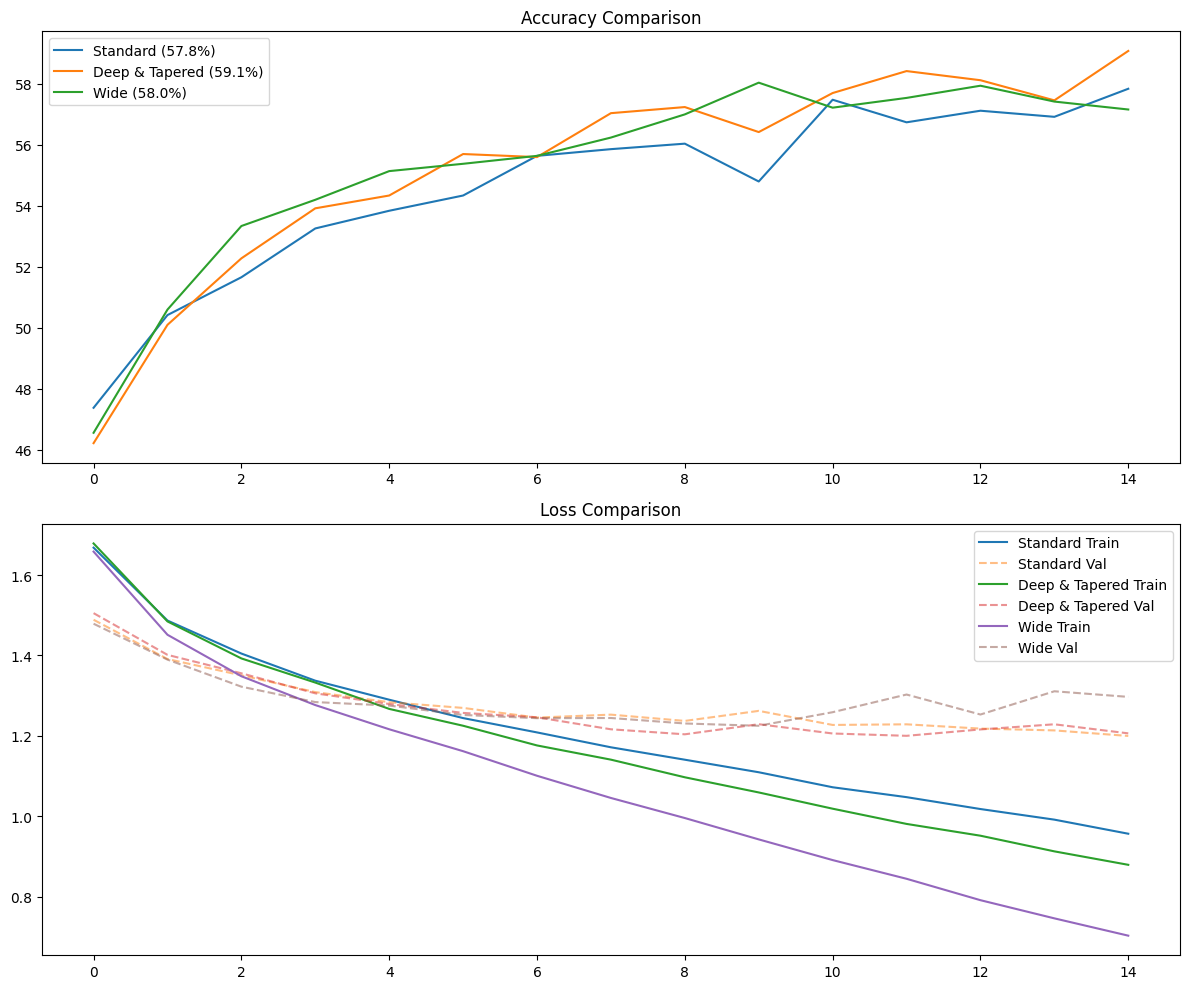


WINNER: Deep & Tapered | FINAL TEST ACCURACY: 57.61%


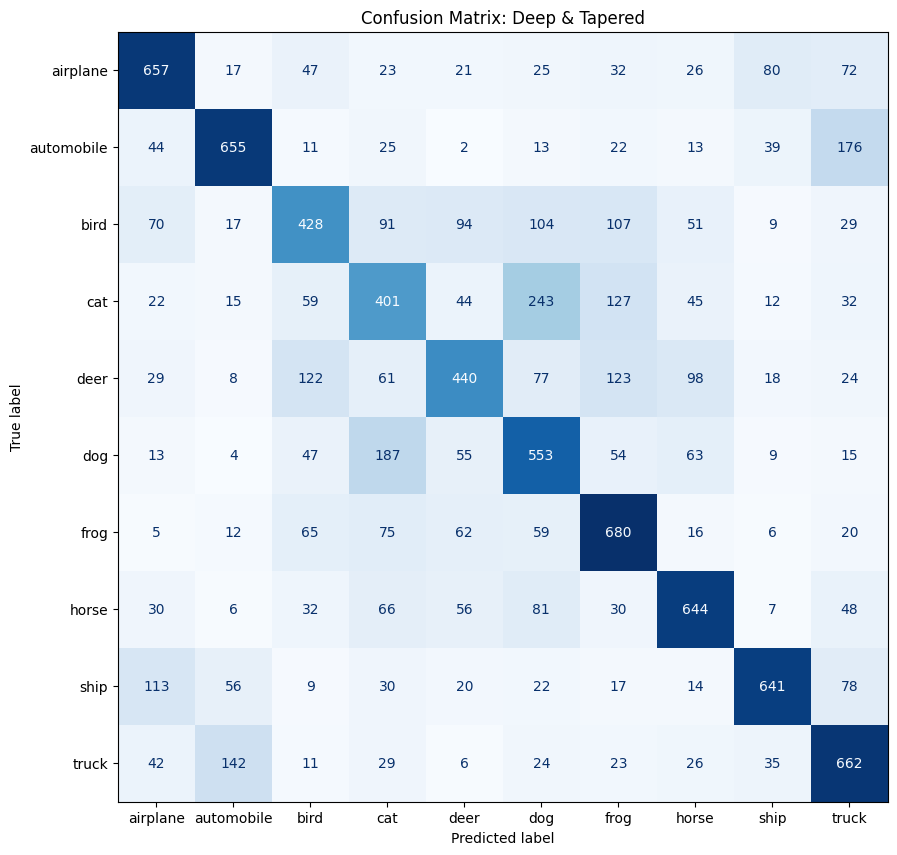

In [5]:
# 1. Plot Accuracy & Loss
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
for name, res in all_results.items():
    ax1.plot(res['history']['val_acc'], label=f"{name} ({res['best_acc']:.1f}%)")
    ax2.plot(res['history']['train_loss'], label=f"{name} Train")
    ax2.plot(res['history']['val_loss'], '--', label=f"{name} Val", alpha=0.5)

ax1.set_title("Accuracy Comparison"); ax1.legend()
ax2.set_title("Loss Comparison"); ax2.legend()
plt.tight_layout(); plt.show()

# 2. Pick Winner and Run Test Set / Confusion Matrix
winner_name = max(all_results, key=lambda x: all_results[x]['best_acc'])
winner_data = all_results[winner_name]

# Load winner into a model
best_model = CifarMLP(3072, next(e['layers'] for e in experiments if e['name'] == winner_name), 10, 0.2).to(device)
best_model.load_state_dict(winner_data['weights'])

y_true, y_pred = [], []
best_model.eval()
with torch.no_grad():
    for imgs, lbls in test_loader:
        imgs, lbls = imgs.to(device), lbls.to(device)
        outs = best_model(imgs)
        y_true.extend(lbls.cpu().numpy())
        y_pred.extend(outs.argmax(1).cpu().numpy())

# Final Accuracy
test_acc = 100 * (np.array(y_true) == np.array(y_pred)).sum() / len(y_true)
print(f"\nWINNER: {winner_name} | FINAL TEST ACCURACY: {test_acc:.2f}%")

# Plot Confusion Matrix
fig, ax = plt.subplots(figsize=(10, 10))
ConfusionMatrixDisplay.from_predictions(y_true, y_pred, display_labels=classes, ax=ax, cmap='Blues', colorbar=False)
plt.title(f"Confusion Matrix: {winner_name}")
plt.show()